# Classification

In [1]:
import pandas as pd

df = pd.read_csv("Hotels_Good_Data.csv",parse_dates=[1,2])
df = df.drop(['Unnamed: 0'],axis=1)
df.head()

,Snapshot Date,Checkin Date,Discount Price,Discount Code,Hotel Name,Day Diff,WeekDay,Discount Diff,Discount Perc
0,2015-07-17,2015-07-18,7.150701,1,Newark Liberty International Airport Marriott,1,5,4.499810,1.886070
1,2015-07-17,2015-07-18,6.244167,2,Howard Johnson Inn Queens,1,5,3.496508,1.795402
2,2015-07-17,2015-07-18,7.126891,2,Home2 Suites by Hilton NY Long Island City Man...,1,5,5.010635,2.375156
3,2015-07-17,2015-07-18,8.188689,2,Park Hyatt New York,1,5,4.605170,0.994252
4,2015-07-17,2015-07-18,6.502790,2,Ramada Staten Island,1,5,4.727388,2.673264


In [2]:
from datetime import datetime

minSnap_date = min(df['Snapshot Date'])
minCheck_date = min(df['Checkin Date'])

df['Snapshot Date']= (df['Snapshot Date']-minSnap_date).dt.days
df['Checkin Date'] = (df['Checkin Date']-minCheck_date).dt.days
df.describe()

,Snapshot Date,Checkin Date,Discount Price,Discount Code,Day Diff,WeekDay,Discount Diff,Discount Perc
count,183485.000000,183485.000000,183485.000000,183485.000000,183485.000000,183485.000000,183485.000000,183485.000000
mean,80.061836,96.526539,7.282917,2.434482,17.464703,2.915944,4.769176,1.995998
std,47.043716,47.662545,0.518688,1.005283,10.041932,1.839661,0.669743,0.602584
min,0.000000,0.000000,5.560682,1.000000,1.000000,0.000000,2.708050,-0.542324
25%,39.000000,55.000000,6.941190,2.000000,9.000000,1.000000,4.248495,1.578666
50%,81.000000,99.000000,7.296413,2.000000,18.000000,3.000000,4.634729,1.953922
75%,115.000000,131.000000,7.581720,3.000000,26.000000,4.000000,5.192957,2.392631
max,168.000000,201.000000,10.263781,4.000000,34.000000,6.000000,8.232174,4.225751


In [3]:
print(minSnap_date)
print(minCheck_date)

2015-07-17 00:00:00
2015-07-18 00:00:00


## Looking for the maximum discount code by group-by

In [4]:
gb_df = df.groupby(['Snapshot Date','Checkin Date','Hotel Name','Day Diff','WeekDay'])
gb_df = df.loc[gb_df['Discount Perc'].idxmax()]
gb_df = gb_df.drop(['Discount Perc','Discount Diff'], axis=1)
gb_df.head()

,Snapshot Date,Checkin Date,Discount Price,Discount Code,Hotel Name,Day Diff,WeekDay
2,0,0,7.126891,2,Home2 Suites by Hilton NY Long Island City Man...,1,5
1,0,0,6.244167,2,Howard Johnson Inn Queens,1,5
7,0,0,7.077498,2,Newark Liberty International Airport Marriott,1,5
3,0,0,8.188689,2,Park Hyatt New York,1,5
8,0,0,6.445720,1,Ramada Staten Island,1,5


### Decision Tree Classification

In [5]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier

#maping Hotel Name
lookup = np.sort(np.unique(gb_df['Hotel Name']))
gb_df['Hotel Name'] = np.searchsorted(lookup,gb_df['Hotel Name'])

tree = DecisionTreeClassifier(class_weight='balanced',max_depth=3,min_samples_split=3)
X=gb_df.drop(['Discount Code'],axis=1)
Y=gb_df['Discount Code']
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.4,random_state=1)
tree.fit(X_train,Y_train)

C:\Users\daniel\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [6]:
from sklearn import metrics

Y_pred = tree.predict(X_test)
print('The Accuracy for this model is -  ',metrics.accuracy_score(Y_test,Y_pred))

The Accuracy for this model is -   0.315293839981


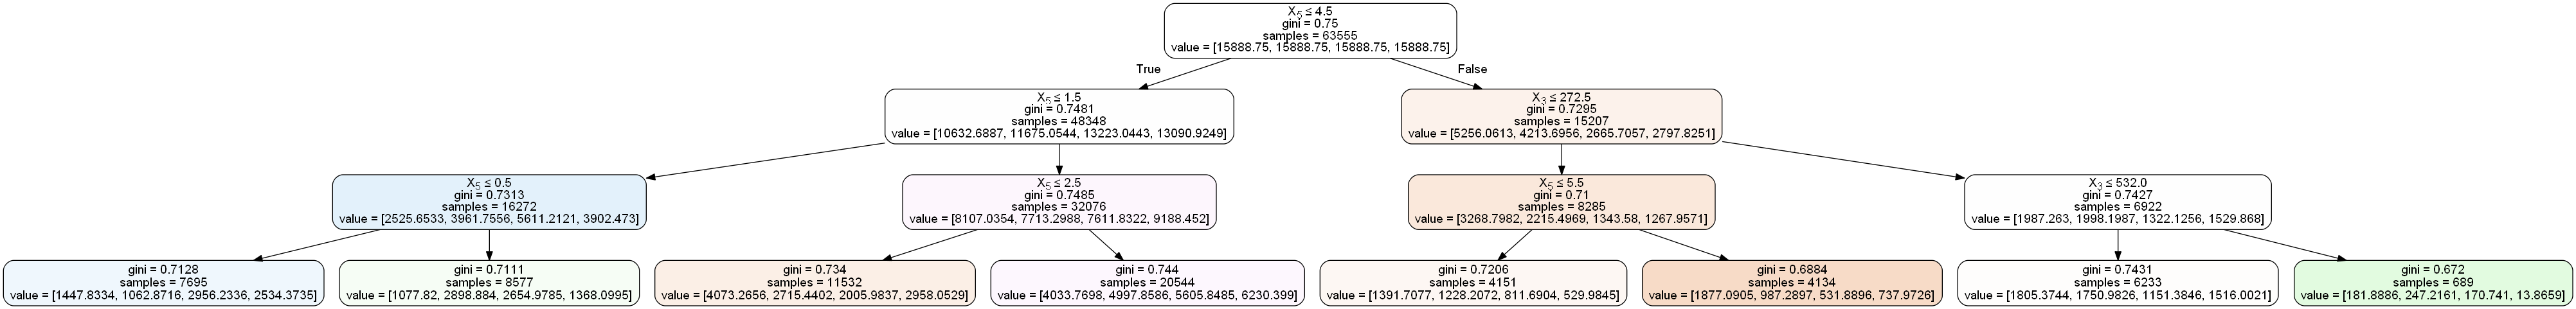

In [7]:
from sklearn.externals.six import StringIO
from IPython.display import Image 
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

h_range = range(1,40)
accuracy=[]
for h in h_range:
    dtci = DecisionTreeClassifier(class_weight='balanced',max_depth=h)
    dtci.fit(X_train,Y_train)
    Y_predi = dtci.predict(X_test)
    accuracy.append(metrics.accuracy_score(Y_test,Y_predi))

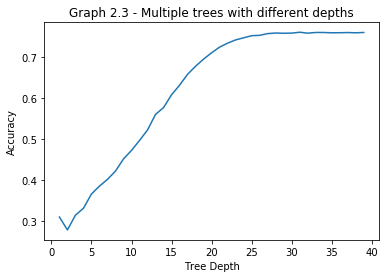

In [9]:
plt.plot(h_range,accuracy)
plt.title('Graph 2.3 - Multiple trees with different depths')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')

In [10]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

tree = DecisionTreeClassifier(class_weight='balanced',max_depth=26)
X=gb_df.drop(['Discount Code'],axis=1)
Y= gb_df['Discount Code']
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.4,random_state=1)

tree.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=26, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [11]:
Y_score = tree.predict(X_test)
print('The Accuracy for this model is -  ',metrics.accuracy_score(Y_test,Y_score))

The Accuracy for this model is -   0.754283691291


In [12]:
print(metrics.classification_report(Y_test,Y_score))

             precision    recall  f1-score   support

          1       0.76      0.76      0.76     10430
          2       0.77      0.76      0.76     13412
          3       0.76      0.75      0.75     11696
          4       0.72      0.73      0.73      6832

avg / total       0.75      0.75      0.75     42370



<blockquote>
    <h4>Tree Classifier Results</h4>
    <p>We trained SKLEARN tree classifier algorithm and we recieved 0.736 accuracy which is a pretty decent accuracy
        for a tree classifier.</p>
    <p>Another thing that we can reffer from graph 2.3 is that after a certain splits amount, which is arround 20 splits, that the tree accuracy for the classification is stable, we think that the reason for that is that the
    samples stopped contribute in a certain branch to the branch entropy, which is 20 in depth here , therefore the graph's curve stays stable.</p>
</blockquote>

### Checking features importance

([<matplotlib.axis.XTick at 0x1c552a17518>,
 <a list of 6 Text xticklabel objects>)

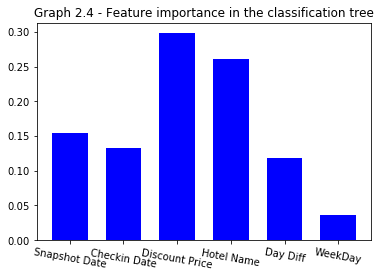

In [13]:
y = tree.feature_importances_
N = len(y)
x = X.columns
width = 1/1.5

g=plt.bar(np.arange(len(x)), y, width, color="blue")
plt.title('Graph 2.4 - Feature importance in the classification tree')
plt.xticks(np.arange(len(x)),x,rotation=-10)

<blockquote>
    <h4>Feature importance conclusions</h4>
    <p>We can learn from graph 2.4 that the  most important features is the hotel name, Snapshot Date, Checkin Date, Day Diff and then the Week Day.
    The reason that the Hotel Name is the most important feature for the tree is as we could see from graph 1.45 in the preprocessing section is that the hotel distributions for each code is that he's Information Gain is the highest and helps the classification process distribution.</p>
    <p>Another issue is the week day contribution, we believe that the low contribution of the week day is, as we can see from graph 1.5 earlier, that the Information Gain of it is pretty low, due to its low distribution of he's values.</p>
</blockquote>

### ROC And True Positive and Negetivae info

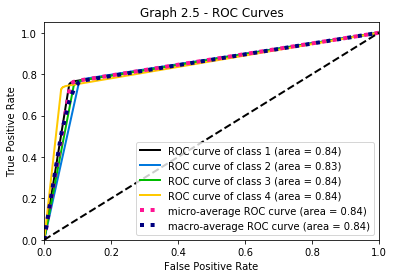

In [14]:
#import sklearn
import scikitplot as skplt

y_probas = tree.predict_proba(X_test)
tr_probas = y_probas
tr_test = Y_test
skplt.metrics.plot_roc(Y_test, y_probas)
plt.title('Graph 2.5 - ROC Curves')
plt.show()

In [15]:
p = metrics.confusion_matrix(Y_test,Y_score)
TP = p[0,0]
FP = p[0,1]
TN = p[1,0]
FN = p[1,1]
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(TN+FP)
FNR = FN/(FN+TP)
print("TP: ",TP)
print("FP: ",FP)
print("TN: ",TN)
print("FN: ",FN)
print("TPR: ",TPR)
print("FPR: ",FPR)
print("TNR: ",TNR)
print("FNR: ",FNR)

TP:  7893
FP:  1171
TN:  1197
FN:  10225
TPR:  0.435644110829
FPR:  0.494510135135
TNR:  0.505489864865
FNR:  0.564355889171


<blockquote>
    <h4>Statistical measurements of our tree classifier</h4>
    <p>From graph 2.5 you can learn from the ROC curve that the 'knee' spot is a bit low from her ideal spot, so we can suspect that there is that the True Positive rate is a bit low, actually as we can see the TPR is 0.43 which is a pretty low value, even less then the FPR.</p>
    <p>Farther more we can see that the FN value is very high, so the algorithm mistake lies in a false negative wrong classification, maybe because the tree classification is based on linear distributions for each new branch, and our data distribution by those parameters is too distribute, as we can see in the begining of the document</p>
</blockquote>

### Naive Bayes classification

#### Scaling and Classifing with down-sampling

In [16]:
#Downsmapling data

chosen1 = np.random.choice(gb_df[gb_df['Discount Code'] == 1].index,9000,replace = False)
chosen2 = np.random.choice(gb_df[gb_df['Discount Code'] == 2].index,16000,replace = False)
chosen3 = np.random.choice(gb_df[gb_df['Discount Code'] == 3].index,12000,replace = False)

df_downsmapled = gb_df.drop(chosen1)
df_downsmapled = df_downsmapled.drop(chosen2)
df_downsmapled = df_downsmapled.drop(chosen3)


df_downsmapled.groupby(by='Discount Code').size()

Discount Code
1    16717
2    17593
3    17470
4    17145
dtype: int64

In [17]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from sklearn.naive_bayes import MultinomialNB
gnb = MultinomialNB()#priors=[0.26,0.19,0.24,0.31])
X=df_downsmapled.drop(['Discount Code'],axis=1)
Y=df_downsmapled['Discount Code']
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.4,random_state=1)

gnb.fit(X_train,Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [18]:
Y_score = gnb.predict(X_test)
print('The Accuracy for this model is -  ',metrics.accuracy_score(Y_test,Y_score))

The Accuracy for this model is -   0.279216539717


In [19]:
print(metrics.classification_report(Y_test,Y_score))

             precision    recall  f1-score   support

          1       0.29      0.18      0.22      6740
          2       0.27      0.44      0.34      7097
          3       0.32      0.09      0.14      6982
          4       0.28      0.40      0.33      6751

avg / total       0.29      0.28      0.26     27570



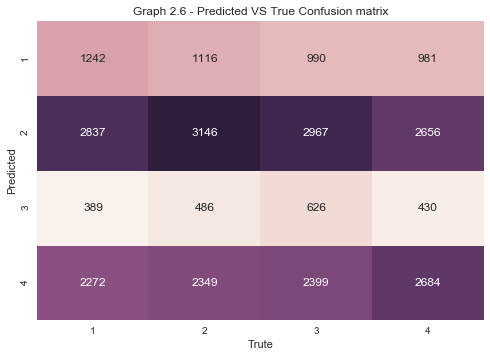

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(Y_score,Y_test)
names = np.unique(Y_score)
sns.heatmap(mat,annot=True,fmt='d',cbar=False,xticklabels=names,yticklabels=names)
plt.xlabel('Trute')
plt.ylabel('Predicted')
plt.title('Graph 2.6 - Predicted VS True Confusion matrix')

<blockquote>
    <h4>Naive Bayes Classifier Results</h4>
    <p>We can see from the accuracy result 0.2818, low balanced precision and graph 2.6. </p>
    <p>From observation on graph 2.6 we can learn that the error distributed equally, that points that our data is not suited for the naive bayes classifier due to it features high distribution and lots of varied values. </p>
</blockquote>

### Checking features importance

In [21]:
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.columns
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j] for j in top10)))

print('Features importance from right to left: \n')
print_top10(X_train,gnb,gnb.classes_)

Features importance from right to left: 

1: WeekDay, Discount Price, Day Diff, Snapshot Date, Checkin Date, Hotel Name
2: WeekDay, Discount Price, Day Diff, Snapshot Date, Checkin Date, Hotel Name
3: WeekDay, Discount Price, Day Diff, Snapshot Date, Checkin Date, Hotel Name
4: WeekDay, Discount Price, Day Diff, Snapshot Date, Checkin Date, Hotel Name


<blockquote>
    <h4>Feature importance conclusions</h4>
    <p>From observence on the feature importance from above we can learn that for all classes the feature importance in naive bayes is the same, first the Hotel Name Feature, then Checkin Date, Snapshot Date, Day Diff and Week Day.</p>
    <p>We believe that the reaso that the 'Hotel Name' feature is the most importent feature is that , as the same as the tree classifier, has the highest information gain, and therefore the main contributer to our classification problem. </p>
</blockquote>

### ROC And True Positive and Negetivae info

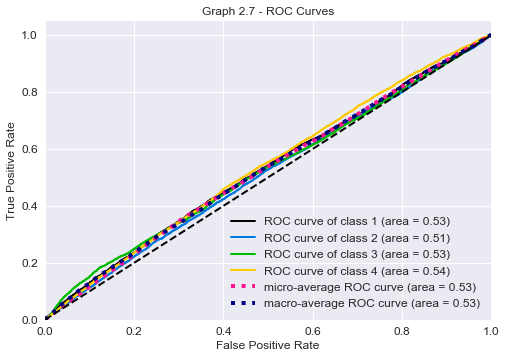

In [22]:
y_probas = gnb.predict_proba(X_test)
skplt.metrics.plot_roc(Y_test, y_probas)
plt.title('Graph 2.7 - ROC Curves')
plt.show()

In [23]:
p = metrics.confusion_matrix(Y_test,Y_score)
TP = p[0,0]
FP = p[0,1]
TN = p[1,0]
FN = p[1,1]
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(TN+FP)
FNR = FN/(FN+TP)
print("TP: ",TP)
print("FP: ",FP)
print("TN: ",TN)
print("FN: ",FN)
print("TPR: ",TPR)
print("FPR: ",FPR)
print("TNR: ",TNR)
print("FNR: ",FNR)

TP:  1242
FP:  2837
TN:  1116
FN:  3146
TPR:  0.283044667274
FPR:  0.717682772578
TNR:  0.282317227422
FNR:  0.716955332726


<blockquote>
    <h4>Statistical measurements of our Naive Bayes classifier</h4>
    <p>From graph 2.7 we can see that Naive Bayes has done low performence job also on the training process.</p>
    <p>We can observe on the knee spot in graph 2.7 and see that its pretty way off, we belive that the reason for that          is because of the high FPR and FNR in-front of the low TPR and TNR on the other hand, as you can also see in the low TN and TP vs the high FN and FP.</p>
<blockquote>

## Scaling and Classifing with Up-sampling

In [24]:
#Upsmapling data

from sklearn.utils import resample

df_majority = gb_df[gb_df['Discount Code'] == 2]
df_minority1 = gb_df[gb_df['Discount Code'] == 1]
df_minority4 = gb_df[gb_df['Discount Code'] == 4]
df_minority3 = gb_df[gb_df['Discount Code'] == 3]

df_minority_upsampled1 = resample(df_minority1,replace=True,n_samples=7000)
df_minority_upsampled3 = resample(df_minority3,replace=True,n_samples=4000)
df_minority_upsampled4 = resample(df_minority4,replace=True,n_samples=16000)
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([gb_df, df_minority_upsampled1])
df_upsampled = pd.concat([df_upsampled, df_minority_upsampled3])
df_upsampled = pd.concat([df_upsampled, df_minority_upsampled4])

# Display new class counts
df_upsampled.groupby(by='Discount Code').size()

Discount Code
1    32717
2    33593
3    33470
4    33145
dtype: int64

In [25]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

gnb = MultinomialNB()#priors=[0.26,0.19,0.24,0.31])
X=df_upsampled.drop(['Discount Code'],axis=1)
Y=df_upsampled['Discount Code']
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.4,random_state=1)

gnb.fit(X_train,Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [26]:
Y_score = gnb.predict(X_test)
print('The Accuracy for this model is -  ',metrics.accuracy_score(Y_test,Y_score))

The Accuracy for this model is -   0.284972728983


[4 4 2 ..., 2 3 2]


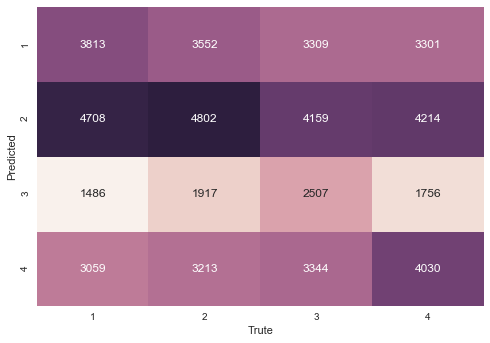

In [27]:
mat = confusion_matrix(Y_score,Y_test)
names = np.unique(Y_score)
sns.heatmap(mat,annot=True,fmt='d',cbar=False,xticklabels=names,yticklabels=names)
plt.xlabel('Trute')
plt.ylabel('Predicted')
print(Y_score)

### Checking features importance

In [28]:
print('Features importance from right to left: \n')
print_top10(X_train,gnb,gnb.classes_)

Features importance from right to left: 

1: WeekDay, Discount Price, Day Diff, Snapshot Date, Checkin Date, Hotel Name
2: WeekDay, Discount Price, Day Diff, Snapshot Date, Checkin Date, Hotel Name
3: WeekDay, Discount Price, Day Diff, Snapshot Date, Checkin Date, Hotel Name
4: WeekDay, Discount Price, Day Diff, Snapshot Date, Checkin Date, Hotel Name


### ROC And True Positive and Negetivae info

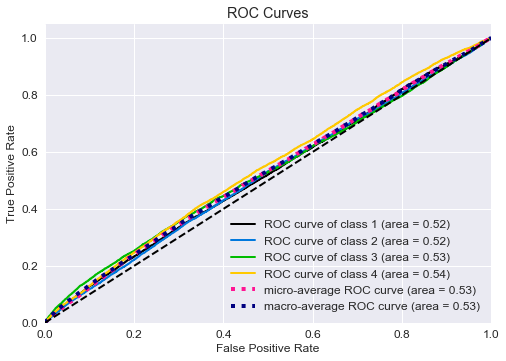

In [29]:
y_probas = gnb.predict_proba(X_test)
nb_probas = y_probas
nb_test = Y_test
skplt.metrics.plot_roc(Y_test, y_probas)
plt.show()

In [30]:
print(metrics.classification_report(Y_test,Y_score))

             precision    recall  f1-score   support

          1       0.27      0.29      0.28     13066
          2       0.27      0.36      0.31     13484
          3       0.33      0.19      0.24     13319
          4       0.30      0.30      0.30     13301

avg / total       0.29      0.28      0.28     53170



In [31]:
p = metrics.confusion_matrix(Y_test,Y_score)
TP = p[0,0]
FP = p[0,1]
TN = p[1,0]
FN = p[1,1]
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(TN+FP)
FNR = FN/(FN+TP)
print("TP: ",TP)
print("FP: ",FP)
print("TN: ",TN)
print("FN: ",FN)
print("TPR: ",TPR)
print("FPR: ",FPR)
print("TNR: ",TNR)
print("FNR: ",FNR)

TP:  3813
FP:  4708
TN:  3552
FN:  4802
TPR:  0.442600116077
FPR:  0.569975786925
TNR:  0.430024213075
FNR:  0.557399883923


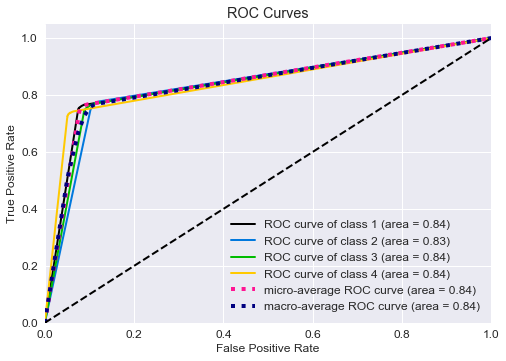

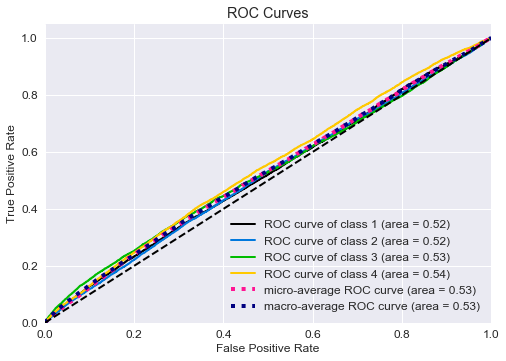

In [32]:
skplt.metrics.plot_roc(tr_test, tr_probas)
skplt.metrics.plot_roc(nb_test, nb_probas)
plt.show()

<blockquote>
    <h3>The difference between classifiers</h3>
    <p>To Conclude, the tree classifier has done a much better job from the naive bayes one, we can see that in the accuracy scores, in the ROC curves, and the most by the graphs.</p>
    <p>The most significant reason that stands in first that the tree classifier performes better is that our data more suited for the tree classification then the naive bayes, which just doesn't work here.</p>
    <p>The true reason for the failure of naive bayes is that our data is very distributed by it's amounts per each values, but meanwhile has insights in its ranges in the features, thats excectly the right data for the tree and a poor data for the naive bayes, because naive bayes works on the distribution of our amounts per feature values, while the tree classifier works on features information gain.</p>
</blockquote>

# Regression Algorithms

### Splitting Dataset to Regression and Classification Datasets and dropping duplicates

In [33]:
reg_data , class_data =train_test_split(df,test_size=0.5)
reg_data['Hotel Name']=np.searchsorted(lookup,reg_data['Hotel Name'])
class_data['Hotel Name']=np.searchsorted(lookup,class_data['Hotel Name'])
class_data.drop_duplicates(subset=['Snapshot Date','Checkin Date','Hotel Name','Day Diff','WeekDay','Discount Diff'],inplace=True)
class_data.count()

C:\Users\daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

Snapshot Date     88726
Checkin Date      88726
Discount Price    88726
Discount Code     88726
Hotel Name        88726
Day Diff          88726
WeekDay           88726
Discount Diff     88726
Discount Perc     88726
dtype: int64

In [34]:
reg_data.drop_duplicates(subset=['Snapshot Date','Checkin Date','Hotel Name','Day Diff','WeekDay','Discount Diff'],inplace=True)
reg_data.count()

C:\Users\daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Snapshot Date     88692
Checkin Date      88692
Discount Price    88692
Discount Code     88692
Hotel Name        88692
Day Diff          88692
WeekDay           88692
Discount Diff     88692
Discount Perc     88692
dtype: int64

## Decision Tree Regression

In [35]:
from sklearn.tree import DecisionTreeRegressor
regrt = DecisionTreeRegressor()
X=reg_data.drop(['Discount Diff','Discount Perc'],axis=1)
Y=reg_data['Discount Perc']
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.4,random_state=1)
regrt.fit(X_train,Y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [36]:
Y_pred = regrt.predict(X_test)
print('The average-error in  percentage is -  ',np.sum(np.abs(Y_test.get_values()-Y_pred))/len(Y_pred))

The average-error in  percentage is -   0.218411105021


## KNN Regression

In [37]:
# We balanced the data distribution for the Discount Code in order to fit to KNN
knn_data= reg_data.groupby('Discount Code')
knn_data= pd.DataFrame(knn_data.apply(lambda x: x.sample(knn_data.size().min()).reset_index(drop=True)))

In [38]:
from sklearn.neighbors import KNeighborsRegressor
regrknn = KNeighborsRegressor(n_neighbors=300)
X=knn_data.drop(['Discount Diff','Discount Perc'],axis=1)
Y=knn_data['Discount Perc']
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.4,random_state=1)
regrknn.fit(X_train,Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=300, p=2,
          weights='uniform')

In [39]:
Y_pred = regrknn.predict(X_test)
print('The average-error in  percentage is -  ',np.sum(np.abs(Y_test.get_values()-Y_pred))/len(Y_pred))

The average-error in  percentage is -   0.453065427716


## SGD Regression

In [40]:
from sklearn import linear_model
regrsgd = linear_model.SGDRegressor(n_iter=200)
X=reg_data.drop(['Discount Diff','Discount Perc'],axis=1)
Y=reg_data['Discount Perc']
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.4,random_state=1)
regrsgd.fit(X_train,Y_train)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=200, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [41]:
Y_pred = regrsgd.predict(X_test)
print('The average-error in  percentage is -  ',np.sum(np.abs(Y_test.get_values()-Y_pred))/len(Y_pred))

The average-error in  percentage is -   2.32552187882e+12


# Classification Algorithms

In [42]:
# A function to predict the right Maximum-Discount-Code Y for a given parameters set X by a given regressor reg_model
def transform__XTTO_calssification(x,y,reg_model):
    for index, row in x.iterrows():
        max_amnt = 0
        for num in range(1,5):
            row['Discount Code'] = num
            dis_amnt = reg_model.predict(row)
            if(max_amnt < dis_amnt):
                max_amnt = dis_amnt
                y.set_value(index,row['Discount Code'])

## Decision Tree Classifiers

### Decision Tree with Decision Tree Regressor

In [43]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

treeTree = DecisionTreeClassifier(class_weight='balanced')
X=class_data.drop(['Discount Code','Discount Diff','Discount Perc'],axis=1)
Y=class_data['Discount Code']
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.4,random_state=1)

transform__XTTO_calssification(X_train,Y_train,regrt)
transform__XTTO_calssification(X_test,Y_test,regrt)

treeTree.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [44]:
Y_pred = treeTree.predict(X_test)
print('The Accuracy for this model is -  ',metrics.accuracy_score(Y_test,Y_pred))

The Accuracy for this model is -   0.989095827111


### Decision Tree with KNN Regressor

In [45]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

treeKNN = DecisionTreeClassifier(class_weight='balanced')
X=class_data.drop(['Discount Code','Discount Diff','Discount Perc'],axis=1)
Y=class_data['Discount Code']
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.4,random_state=1)

transform__XTTO_calssification(X_train,Y_train,regrknn)
transform__XTTO_calssification(X_test,Y_test,regrknn)

treeKNN.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [46]:
Y_pred = treeKNN.predict(X_test)
print('The Accuracy for this model is -  ',metrics.accuracy_score(Y_test,Y_pred))

The Accuracy for this model is -   0.44966329492


### Decision Tree with SGD Regressor

In [47]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

treeSGD = DecisionTreeClassifier(class_weight='balanced')
X=class_data.drop(['Discount Code','Discount Diff','Discount Perc'],axis=1)
Y=class_data['Discount Code']
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.4,random_state=1)

transform__XTTO_calssification(X_train,Y_train,regrsgd)
transform__XTTO_calssification(X_test,Y_test,regrsgd)

treeSGD.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [48]:
Y_pred = treeSGD.predict(X_test)
print('The Accuracy for this model is -  ',metrics.accuracy_score(Y_test,Y_pred))

The Accuracy for this model is -   0.608323236877


## Naive bayes classifiers

### Naive bayes with Decision Tree Regressor

In [49]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from sklearn.naive_bayes import GaussianNB

gnbTree = GaussianNB()
X=class_data.drop(['Discount Code','Discount Diff','Discount Perc'],axis=1)
Y=class_data['Discount Code']
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.4,random_state=1)
transform__XTTO_calssification(X_train,Y_train,regrt)
transform__XTTO_calssification(X_test,Y_test,regrt)
gnbTree.fit(X_train,Y_train)

GaussianNB(priors=None)

In [50]:
Y_pred = gnbTree.predict(X_test)
print('The Accuracy for this model is -  ',metrics.accuracy_score(Y_test,Y_pred))

The Accuracy for this model is -   0.661576174241


### Naive Bayes with KNN Regressor

In [51]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

gnbKNN = GaussianNB()
X=class_data.drop(['Discount Code','Discount Diff','Discount Perc'],axis=1)
Y=class_data['Discount Code']
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.4,random_state=1)

transform__XTTO_calssification(X_train,Y_train,regrknn)
transform__XTTO_calssification(X_test,Y_test,regrknn)

gnbKNN.fit(X_train,Y_train)

GaussianNB(priors=None)

In [52]:
Y_pred = gnbKNN.predict(X_test)
print('The Accuracy for this model is -  ',metrics.accuracy_score(Y_test,Y_pred))

The Accuracy for this model is -   0.46679439858


### Naive Bayes with SGD Regressor

In [53]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

gnbSGD = GaussianNB()
X=class_data.drop(['Discount Code','Discount Diff','Discount Perc'],axis=1)
Y=class_data['Discount Code']
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.4,random_state=1)

transform__XTTO_calssification(X_train,Y_train,regrsgd)
transform__XTTO_calssification(X_test,Y_test,regrsgd)

gnbSGD.fit(X_train,Y_train)

GaussianNB(priors=None)

In [54]:
Y_pred = gnbSGD.predict(X_test)
print('The Accuracy for this model is -  ',metrics.accuracy_score(Y_test,Y_pred))

The Accuracy for this model is -   0.341100560706
